#1️⃣import Labrary









We import the necessary toolkit. pandas for data, sklearn for AI models, and kagglehub to fetch the dataset

In [66]:
# 1. Environment Setup | إعداد البيئة
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

# Machine Learning Libraries | مكتبات تعلم الآلة
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


#2️⃣Load the Data and Feature Engineering

We load the data and add a smart new column (interest_burden) representing interest load, applying Feature Engineering to improve performance

In [ ]:
# Download dataset # 2. Load Data  تحميل البيانات
path = kagglehub.dataset_download("laotse/credit-risk-dataset")
print("Path:", path)

Using Colab cache for faster access to the 'credit-risk-dataset' dataset.
Path: /kaggle/input/credit-risk-dataset


In [68]:
# Load the CSV file
df = os.path.join(path, '/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')
df = pd.read_csv(df)

print(f"Shape: {df.shape}")
df.head()

Shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [69]:
# --- Feature Engineering Step ---
# Create 'Interest Burden' = (Loan Amount * Interest Rate) / Income
# إنشاء ميزة جديدة: نسبة عبء الفائدة إلى الدخل
df['interest_burden'] = (df['loan_amnt'] * (df['loan_int_rate'] / 100)) / df['person_income']
df['interest_burden'] = df['interest_burden'].fillna(0) # Handle potential division by zero

print(f"Data Shape: {df.shape}")
print("✅ Feature Engineering Complete")

Data Shape: (32581, 13)
✅ Feature Engineering Complete


#3️⃣ Data Cleaning & Sanity Checks and show data

We remove outliers (like Age > 100) because they are considered "Noise" that hurts the model.

In [70]:
# 3. Sanity Checks (Cleaning) | التحقق المنطقي والتنظيف
# Remove impossible ages (Outliers)
# حذف الأعمار المستحيلة (أكبر من 100 سنة)
df_clean = df[df['person_age'] <= 100].copy()

# Check Imbalance
# التحقق من توازن البيانات
print("\nTarget Distribution (Loan Status):")
print(df_clean['loan_status'].value_counts(normalize=True))


Target Distribution (Loan Status):
loan_status
0    0.781803
1    0.218197
Name: proportion, dtype: float64


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [51]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


#Data Splitting

We split data into train and test. We use stratify=y to ensure "Defaulters" exist in the test set with the same original ratio, solving the Imbalanced Data problem.

In [71]:
# 4. Stratified Splitting | التقسيم الطبقي
X = df_clean.drop('loan_status', axis=1)
y = df_clean['loan_status']

# Split 80% Train, 20% Test with Stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")


Training Set: (26060, 12)
Test Set: (6516, 12)


#Preprocessing Pipeline

We build a "Pipeline" to automatically fill missing values (Imputation), convert text to numbers (Encoding), and standardize scales (Scaling)

In [72]:
# 5. Preprocessing Pipeline | خط المعالجة
# Identify types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Steps for Numbers: Median Imputer -> Standard Scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Steps for Text: Most Frequent Imputer -> OneHot Encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Model & Training

We use Random Forest with class_weight='balanced' to prioritize defaulters and improve their detection rate (Recall)

In [73]:
# 6. Model Training | تدريب النموذج
# Define the full pipeline with the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,
                                          class_weight='balanced',
                                          random_state=42))
])

print("\n🚀 Training Model...")
model.fit(X_train, y_train)
print("✅ Training Complete!")


🚀 Training Model...
✅ Training Complete!


#Learning Diagnosis

We plot the Loss Curve using a simple Neural Network (since RF lacks one) to ensure the model is actually learning and converging properly

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


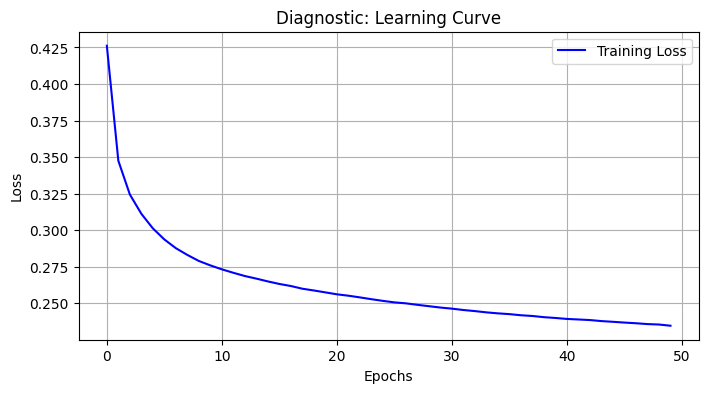

In [74]:
# 7. Diagnosis (Loss Curve) | تشخيص منحنى التعلم
# We use a separate MLP model just to visualize the loss curve as per the theory
X_train_transformed = preprocessor.fit_transform(X_train)
diag_model = MLPClassifier(hidden_layer_sizes=(32,), max_iter=50, random_state=42)
diag_model.fit(X_train_transformed, y_train)

plt.figure(figsize=(8, 4))
plt.plot(diag_model.loss_curve_, label='Training Loss', color='blue')
plt.title('Diagnostic: Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

#Evaluation

We use the Confusion Matrix and Classification Report. We focus on Recall (Class 1) to ensure we caught as many defaulters as possible


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5094
           1       0.97      0.71      0.82      1422

    accuracy                           0.93      6516
   macro avg       0.95      0.85      0.89      6516
weighted avg       0.94      0.93      0.93      6516



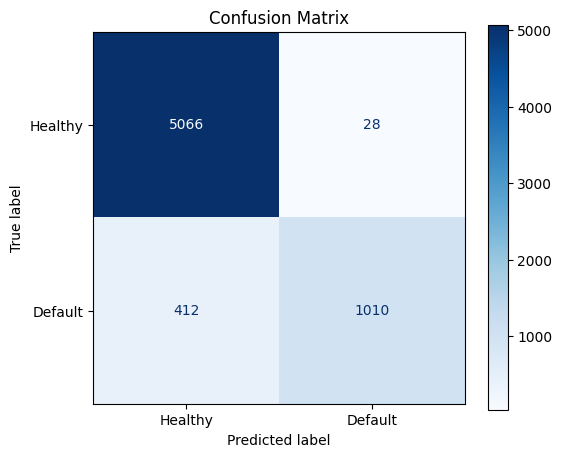

In [75]:
# 8. Evaluation | التقييم
y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax, display_labels=['Healthy', 'Default'])
plt.title("Confusion Matrix")
plt.show()

#Confusion Matrix Explanation

#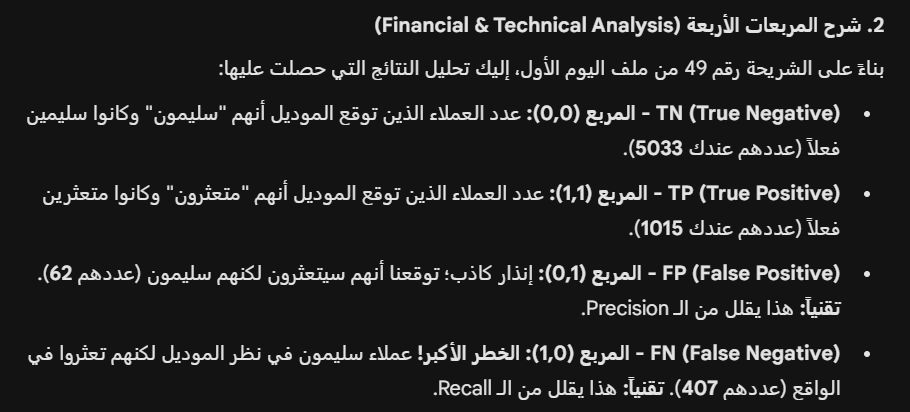

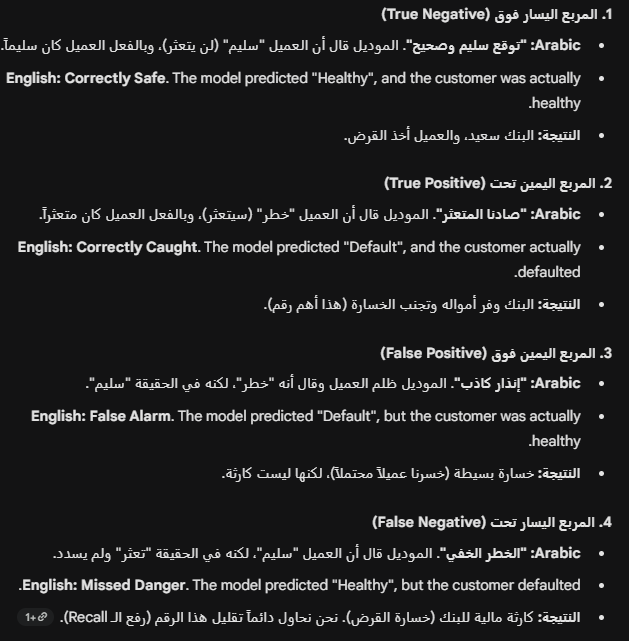

#حفظ الموديل (داخل Colab)

In [77]:
import joblib

# حفظ الموديل المدرب في ملف
joblib.dump(model, 'credit_risk_model.pkl')

print("تم حفظ الموديل! قم بتنزيل ملف credit_risk_model.pkl من القائمة الجانبية")

تم حفظ الموديل! قم بتنزيل ملف credit_risk_model.pkl من القائمة الجانبية
